# Audiobooks Conversion Rate

### Introduction
Given 2 & 1/2 years of data from audiobook app., I created a ML algorithm to predict conversion rate of customers. Using this algorithm, advertising dollars spent on customers who are not likely to purchase again can be reduced. This saved money can be spent on advertising to new customers to create value and growth opportunities.

**Note**<br>
An interactive dashboard that shows the effect of reviews on sales and audiobook ratings is available at this web address: <br>
https://public.tableau.com/profile/john.abounassar#!/vizhome/AudiobookConversions/Dashboard1

### Data Summary
You have a .csv summarizing the data. There are several variables including: 
* Customer ID
* Book length overall (sum of the minute length of all purchases)
* Book length avg (average length in minutes of all purchases)
* Price paid_overall (sum of all purchases) 
* Price Paid avg (average of all purchases) 
* Review (a Boolean variable whether the customer left a review)
* Review out of 10 (if the customer left a review, his/her review out of 10 
* Total minutes listened
* Completion (from 0 to 1)
* Support requests (number of support requests; everything from forgotten password to assistance for using the App), and Last visited minus purchase date (in days).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import scale,StandardScaler,MinMaxScaler
%matplotlib inline

#### Load in the dataset
Do some basic exploration to understand the data we're working with.

In [2]:
data = pd.read_csv('Audiobook data - raw.csv')
X = data.drop(['Targets','ID'], axis=1)
y = data['Targets']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14084 entries, 0 to 14083
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 14084 non-null  int64  
 1   Book Length Overall (mins)         14084 non-null  float64
 2   Book Length Avg (mins)             14084 non-null  int64  
 3   Price Avg                          14084 non-null  float64
 4   Price Overall                      14084 non-null  float64
 5   Review                             14084 non-null  int64  
 6   Review 10/10                       14084 non-null  float64
 7   Completion                         14084 non-null  float64
 8   Minutes Listened                   14084 non-null  float64
 9   Support Requests                   14084 non-null  int64  
 10  Last visited Minus Purchase Dates  14084 non-null  int64  
 11  Targets                            14084 non-null  int

In [3]:
data.describe()

,ID,Book Length Overall (mins),Book Length Avg (mins),Price Avg,Price Overall,Review,Review 10/10,Completion,Minutes Listened,Support Requests,Last visited Minus Purchase Dates,Targets
count,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000,14084.000000
mean,16772.491551,1591.281685,1678.608634,7.102887,7.543805,0.160750,8.909795,0.125659,189.888983,0.070222,61.935033,0.158833
std,9691.807248,504.340663,654.838599,4.930525,5.560129,0.367313,0.643406,0.241206,371.084010,0.472157,88.207634,0.365533
min,2.000000,216.000000,216.000000,3.860000,3.860000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8368.000000,1188.000000,1188.000000,5.330000,5.330000,0.000000,8.910000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,16711.500000,1620.000000,1620.000000,5.950000,6.070000,0.000000,8.910000,0.000000,0.000000,0.000000,11.000000,0.000000
75%,25187.250000,2160.000000,2160.000000,8.000000,8.000000,0.000000,8.910000,0.130000,194.400000,0.000000,105.000000,0.000000
max,33683.000000,2160.000000,7020.000000,130.940000,130.940000,1.000000,10.000000,1.000000,2160.000000,30.000000,464.000000,1.000000


Text(0.5, 1.0, 'Target Distribution')

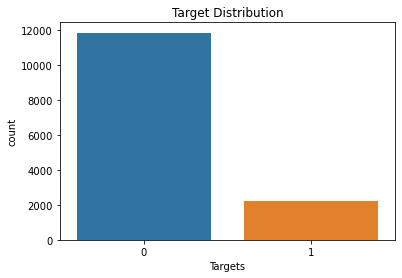

In [4]:
sns.countplot(data['Targets'])
plt.title('Target Distribution')

#### Prepping Data for Tensorflow
* There is a clear discrepancy in the targets for the dataset, this won't do when training the model. We need a somewhat balanced dataset to produce an accurate model. Therefore, we will randomly remove datapoints to balance the dataset.
* We will also normalize, shuffle and convert the data into numpy arrays.

In [5]:
#Balancing dataset so model is BALANCED (conversion rate = 50%). 
#Imbalance in the dataset would ruin the algorithm, therefore..
#Using for loop and a counter to track which indices/observations need to be removed (when 0's > 1's)

conv_targ = data['Targets'].sum()
zero_targ_counter = 0
indices_to_remove = []


for i in range(y.shape[0]):
    if y[i] == 0:
        zero_targ_counter += 1
        if zero_targ_counter > conv_targ:
            indices_to_remove.append(i)

In [6]:
#Number of datapoints to be removed
len(indices_to_remove)

9610

In [7]:
#Balanced inputs/targets, drop indices
X_balanced = X.drop(labels=indices_to_remove)
y_balanced = y.drop(labels=indices_to_remove)

y_balanced.shape, X_balanced.shape

((4474,), (4474, 10))

#### Shuffling the data

In [8]:
shuffled_indices = np.array(list(y_balanced.index))
np.random.shuffle(shuffled_indices)

X_shuffled = X_balanced.reindex(shuffled_indices)
y_shuffled = y_balanced.reindex(shuffled_indices)

#### Standardizing Inputs

In [9]:
X_shuffled.index

Int64Index([ 1969,    10,  7748,  9082,  1600,  1295,   140, 11433,  1859,
            11545,
            ...
             1341,  4229, 13196, 12485,   172,  6741,  5391,  2324,   787,
              715],
           dtype='int64', length=4474)

In [10]:
#Note: This scaling function returns a the scaled data in a numpy array
X_shuffled_array = scale(X_shuffled)

#### Splitting the data into train, val and test

In [13]:
samples_count = X_shuffled.shape[0]

#Splitting number of observations into train,val,test - (80/10/10) split
train_samples_count = int(0.8*samples_count)
val_samples_count = int(0.1*samples_count)
test_samples_count = samples_count - train_samples_count - val_samples_count

#Remember to convert 
train_inputs = X_shuffled_array[:train_samples_count]
train_targets = y_shuffled.values[:train_samples_count]

val_inputs = X_shuffled_array[train_samples_count:train_samples_count + val_samples_count]
val_targets = y_shuffled.values[train_samples_count:train_samples_count + val_samples_count]

test_inputs = X_shuffled_array[train_samples_count + val_samples_count:]
test_targets = y_shuffled.values[train_samples_count + val_samples_count:]

## Creating the model

In [33]:
input_layer = 10
hidden_layer = 75
output_layer = 2


model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units = input_layer))
model.add(tf.keras.layers.Dense(units = 100, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 75, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = output_layer, activation = 'softmax'))


model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [34]:
batch_size = 64
max_epochs = 100

early_stop = tf.keras.callbacks.EarlyStopping(patience = 3)

model.fit(x = train_inputs,
         y = train_targets,
         batch_size = batch_size,
         epochs = max_epochs,
         verbose = 1,
         callbacks = [early_stop],
         validation_data = (val_inputs,val_targets)          
         )

Train on 3579 samples, validate on 447 samples
Epoch 1/100
3579/3579 [==============================] - 0s 138us/sample - loss: 0.5541 - accuracy: 0.6901 - val_loss: 0.4889 - val_accuracy: 0.7562
Epoch 2/100
3579/3579 [==============================] - 0s 26us/sample - loss: 0.4440 - accuracy: 0.7533 - val_loss: 0.4463 - val_accuracy: 0.7584
Epoch 3/100
3579/3579 [==============================] - 0s 27us/sample - loss: 0.3987 - accuracy: 0.7801 - val_loss: 0.4085 - val_accuracy: 0.7942
Epoch 4/100
3579/3579 [==============================] - 0s 30us/sample - loss: 0.3768 - accuracy: 0.7888 - val_loss: 0.3940 - val_accuracy: 0.7942
Epoch 5/100
3579/3579 [==============================] - 0s 27us/sample - loss: 0.3590 - accuracy: 0.8061 - val_loss: 0.3770 - val_accuracy: 0.8143
Epoch 6/100
3579/3579 [==============================] - 0s 27us/sample - loss: 0.3540 - accuracy: 0.7988 - val_loss: 0.3720 - val_accuracy: 0.8188
Epoch 7/100
3579/3579 [==============================] - 0s 38us

In [35]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

448/448 [==============================] - 0s 196us/sample - loss: 0.3427 - accuracy: 0.8192


In [36]:
print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.34. Test accuracy: 81.92%


## Implementation of Algorithm
We will focus on the test data in this section, considering that we have 448 buyers. We will use the model to calculate the potential savings on marketing dollars.

**Assumptions**
* On average a company spends somwhere from 6-10% of it's budget on marketing dollars. 
* Given a budget of 10000 USD that is evenly spent amongst potential return buyers.
* The buyers from this section were from a one month period.
* If the probability an individual will not buy again is below 0.50, they will not be targeted for marketing.

In [46]:
predictions_probabilities = model.predict(test_inputs, batch_size = 64)

def round_prob(probability):
    predictions = []
    for i in probability:
        if i[0] < 0.500000:  
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

predictions = round_prob(predictions_probabilities)

#Get predictions into df
users_likely_to_buy = X_shuffled[train_samples_count + val_samples_count:]
users_likely_to_buy['users_likely_to_buy'] = predictions

195

In [49]:
users_likely_to_buy.describe()

,Book Length Overall (mins),Book Length Avg (mins),Price Avg,Price Overall,Review,Review 10/10,Completion,Minutes Listened,Support Requests,Last visited Minus Purchase Dates,users_likely_to_buy
count,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,1510.553571,1747.767857,7.855089,9.086786,0.194196,8.894866,0.083884,113.339732,0.073661,82.520089,0.435268
std,532.389734,830.758032,5.169065,6.223348,0.396023,0.815197,0.204722,279.765448,0.322772,105.762765,0.496346
min,324.000000,324.000000,3.860000,3.860000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1188.000000,1188.000000,5.330000,5.330000,0.000000,8.910000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1620.000000,1620.000000,6.665000,7.990000,0.000000,8.910000,0.000000,0.000000,0.000000,22.000000,0.000000
75%,2160.000000,2160.000000,8.330000,10.130000,0.000000,8.910000,0.030000,58.590000,0.000000,163.250000,1.000000
max,2160.000000,5508.000000,80.000000,80.000000,1.000000,10.000000,1.000000,1987.200000,2.000000,371.000000,1.000000


**Potential Savings**<br>
For a single month, if this algorithm were to be implemented, we would have a savings of 

This can be found by comparing an ignorant marketing strategy (targeting everybody) vs the algorithms choices and finding the differenct in $ spent. Assuming the budget was 10000 USD, we'd have 10000 to spend on 448 people, which is approximately 22.32 dollars/person.

By using the targeted marketing strategy, we could spend the same amount per person and save 5647.32 dollars. This money could be used to target new potential buyers or increase the quality of marketing products used to target our returning customers.